In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import os
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [21]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [22]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [24]:
# Build a simple feedforward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\arsen\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 25735.1172 - val_loss: 21140.5039 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23426.0332 - val_loss: 16865.4844 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12131.5156 - val_loss: 5809.4053 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4446.3672 - val_loss: 5238.2305 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3255.1833 - val_loss: 2670.1362 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2189.0125 - val_loss: 1169.2255 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1291.6525 - val_loss: 606.4832 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1044.7765 - val_loss: 351.0298 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 681.6277 - v

In [26]:
# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R² Score: 0.9467


In [27]:
# Get the last date
last_index = y_test.tail(1).index[0]

# Convert predictions to Series if needed
if not isinstance(y_pred, pd.Series):
    y_pred = pd.Series(y_pred.flatten(), index=y_test.index)

save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'''
# Create a DataFrame with true, predicted, and timestamp
result_df = pd.DataFrame({
    'Ticker': [tckr] * len(y_test),
    'Actual': y_test.values,
    'Predicted': y_pred.values,
    'Saved': [save_time] * len(y_test),
    'R2 Score': [r2] * len(y_test),
}, index=y_test.index)

'''

# Create a single-row DataFrame for the latest prediction
result_df = pd.DataFrame({
    'Ticker': [tckr],
    'Actual': [y_test.loc[last_index]],
    'Predicted': [y_pred.loc[last_index]],
    'R2 Score': [r2],
    'Saved': [save_time]
}, index=[last_index])

# Reset index and rename as 'Date'
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Date'}, inplace=True)

# Define path
csv_path = 'predictions_log.csv'

# Check if file exists
if os.path.exists(csv_path):
    # Append to the existing file
    result_df.to_csv(csv_path, mode='a', header=False, index=False)
else:
    # Create a new file with headers
    result_df.to_csv(csv_path, mode='w', header=True, index=False)

print(f"✅ Results saved to {csv_path} at {save_time}")

✅ Results saved to predictions_log.csv at 2025-06-05 00:26:36


In [28]:
y_test

Date
2024-05-02    153.760252
2024-05-03    151.928301
2024-05-06    155.726497
2024-05-07    154.661853
2024-05-08    157.683164
                 ...    
2025-05-29     94.760002
2025-05-30     93.459999
2025-06-02     96.430000
2025-06-03     96.050003
2025-06-04     93.940002
Name: Next_High, Length: 273, dtype: float64

In [29]:
y_pred

Date
2024-05-02    151.509262
2024-05-03    152.767044
2024-05-06    152.012589
2024-05-07    154.953522
2024-05-08    154.075241
                 ...    
2025-05-29     98.842117
2025-05-30     97.178490
2025-06-02     96.392235
2025-06-03     97.884682
2025-06-04     98.065536
Length: 273, dtype: float32

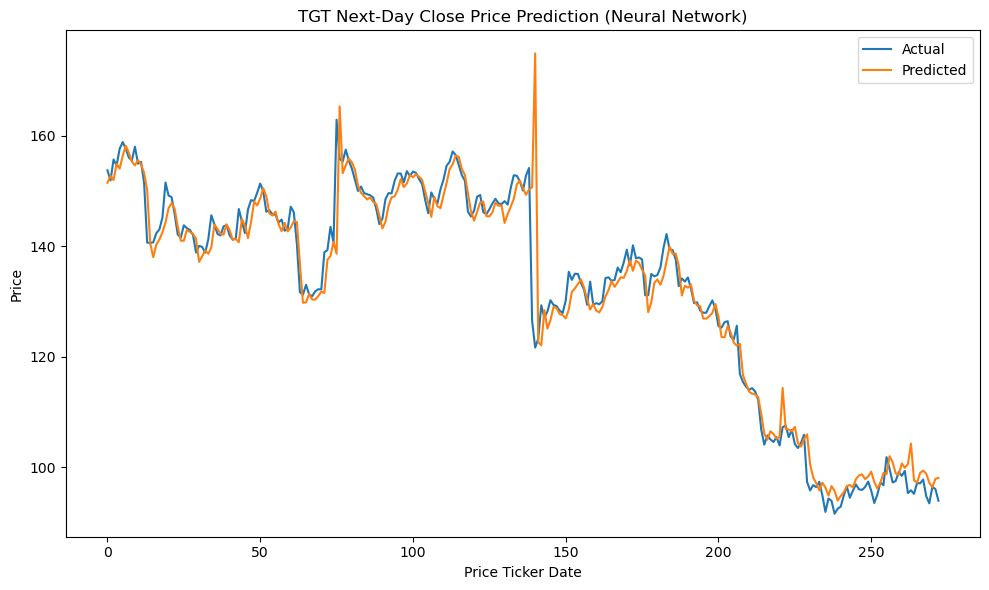

In [30]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Price Ticker Date') #('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

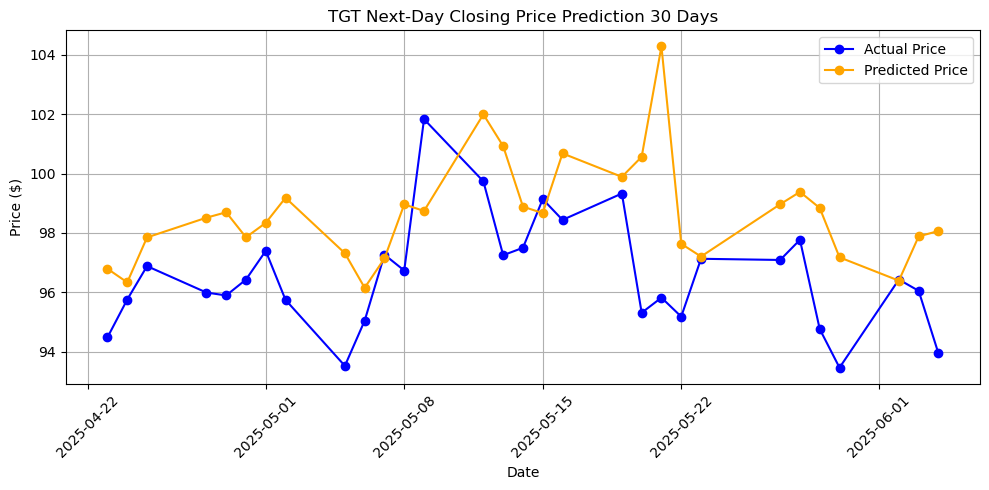

In [31]:
# Extract last 5 days of test predictions and actuals
last_n = 30
y_test_last = y_test[-last_n:]
y_pred_last = y_pred[-last_n:]

# Extract corresponding dates
if isinstance(y_test.index, pd.DatetimeIndex):
    test_dates = y_test.index[-last_n:]
else:
    # fallback if index is not datetime (e.g., RangeIndex)
    test_dates = pd.date_range(end=pd.Timestamp.today(), periods=last_n)

# Plot last week only
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_last.values, label='Actual Price', marker='o', color='blue')
plt.plot(test_dates, y_pred_last, label='Predicted Price', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{tckr} Next-Day Closing Price Prediction {last_n} Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df

Price,Open,High,Low,Close,Volume,Next_High
Ticker,TGT,TGT,TGT,TGT,TGT,
Date,,,,,,
2020-01-02,112.422797,112.562507,109.383868,110.091202,5149800,109.619646
2020-01-03,108.859919,109.619646,108.222440,108.947243,5018500,108.851176
2020-01-06,108.257363,108.851176,107.602422,107.916794,4226900,108.659065
2020-01-07,107.410311,108.659065,107.410311,108.108917,3641600,109.375140
2020-01-08,108.327237,109.375140,107.707221,107.759621,5731600,109.078224
...,...,...,...,...,...,...
2025-05-29,97.769997,97.769997,94.239998,94.870003,7033300,94.760002
2025-05-30,94.040001,94.760002,93.250000,94.010002,7874000,93.459999


In [33]:
# Load the CSV into a DataFrame
df_log = pd.read_csv(csv_path)

# Ensure 'Saved' column is parsed as datetime
df_log['Saved'] = pd.to_datetime(df_log['Saved'])

# Filter by ticker and sort by Saved in descending order
filtered_df = df_log[df_log['Ticker'] == tckr].sort_values(by='Saved', ascending=False)

# Display result
filtered_df

,Date,Ticker,Actual,Predicted,R2 Score,Saved
47,2025-06-04,TGT,93.940002,98.065540,0.946688,2025-06-05 00:26:36
46,2025-06-04,TGT,93.940002,97.377625,0.940585,2025-06-05 00:25:03
45,2025-06-04,TGT,93.940002,96.385544,0.935957,2025-06-04 18:51:15
43,2025-06-04,TGT,93.940002,97.992440,0.944316,2025-06-04 18:43:15
42,2025-06-04,TGT,94.370003,97.961700,0.951387,2025-06-04 12:01:20
41,2025-06-03,TGT,95.779999,97.742120,0.949506,2025-06-04 01:11:38
40,2025-06-03,TGT,95.779999,101.076035,0.925475,2025-06-04 01:08:50
39,2025-06-03,TGT,95.779999,97.986390,0.946095,2025-06-04 01:05:51
38,2025-06-03,TGT,95.779999,98.393660,0.915075,2025-06-04 00:58:00
37,2025-06-03,TGT,95.779999,99.378296,0.873672,2025-06-04 00:56:50


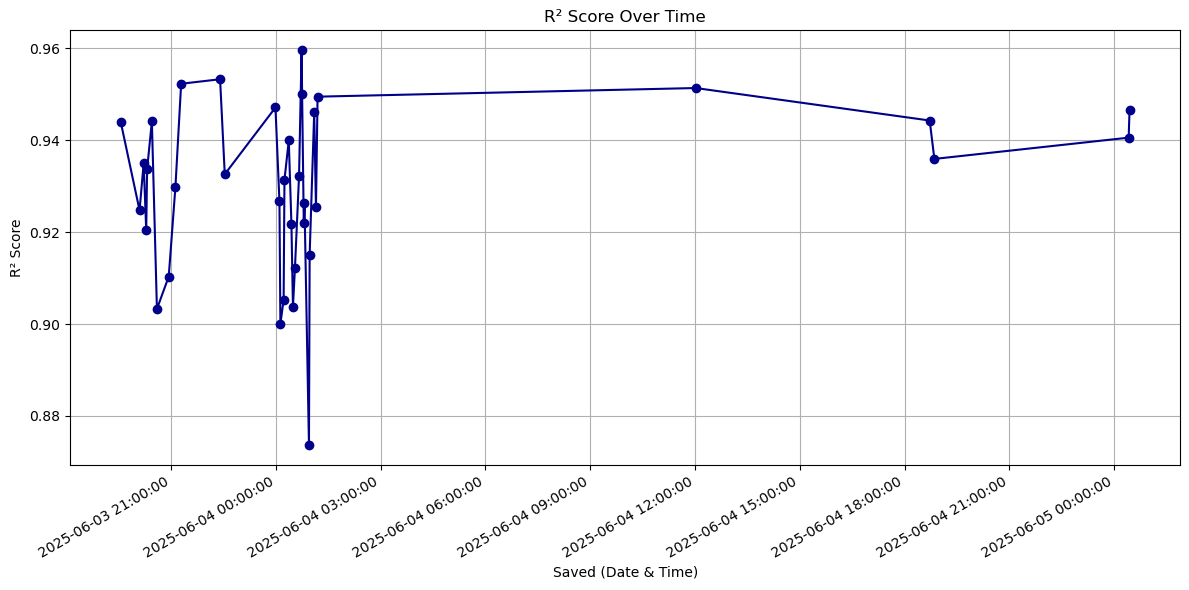

In [34]:
# Convert 'Saved' to datetime
filtered_df['Saved'] = pd.to_datetime(filtered_df['Saved'])

# Plot R² Score over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Saved'], filtered_df['R2 Score'], marker='o', linestyle='-', color='darkblue')

# Formatting full datetime on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels

# Labels and title
plt.xlabel('Saved (Date & Time)')
plt.ylabel('R² Score')
plt.title('R² Score Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
def plot_histogram(simulations, ticker, t):
    final_prices = simulations[:, -1]  # Extract final prices from all simulations
    median_prices = np.median(simulations, axis=0)  # Compute median trajectory

    # Get the actual future prediction date
    prediction_date = (datetime.today() + timedelta(days=t)).strftime("%B %d, %Y")

    p5, p50, p95 = np.percentile(final_prices, [5, 50, 95])
    print(
        f"Monte Carlo Simulation for {ticker} - Projected Price on {prediction_date}:"
    )
    print(f"5th Percentile (Low Risk Estimate): ${p5:.2f}")
    print(f"Median Price (Most Likely Outcome): ${p50:.2f}")
    print(f"95th Percentile (High Reward Estimate): ${p95:.2f}\n")

    # Probability distribution plot (Histogram)
    plt.figure(figsize=(12, 6))
    sns.histplot(final_prices, bins=50, kde=True, color="blue", alpha=0.6)

    # Mark confidence intervals
    plt.axvline(
        p5, color="red", linestyle="dashed", label="5th Percentile (Low Risk)"
    )
    plt.axvline(
        p50,
        color="black",
        linestyle="dashed",
        label="Median Price (Most Likely Outcome)",
    )
    plt.axvline(
        p95,
        color="green",
        linestyle="dashed",
        label="95th Percentile (High Reward)",
    )
    plt.title(
        f"Probability Distribution of {ticker} Stock Price Over {t} Days ({prediction_date})"
    )
    plt.xlabel("Projected Stock Price, $")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [36]:
def plot_paths(simulations, historical_prices, ticker, t):
    # Monte Carlo Simulation Paths
    plt.figure(figsize=(12, 6))

    # Plot simulated paths
    plt.plot(simulations.T, alpha=0.05, color="blue")

    # # Overlay median trajectory (trend indicator)
    # plt.plot(median_prices, color='black', linewidth=2, label="Median Monte Carlo Projection")

    # Overlay actual historical prices for comparison
    plt.plot(
        range(len(historical_prices)),
        historical_prices,
        color="red",
        linewidth=2,
        label=f"Historical trajectory for last {t} days",
    )

    plt.title(f"Monte Carlo Simulation with Trends for {ticker} Over {t} Days")
    plt.xlabel("Days")
    plt.ylabel("Projected Stock Price, $")
    plt.legend()
    plt.show()

In [37]:
def monte_carlo(ticker, num_simulations=1000):
    stock_data = yf.download(ticker, start='2020-01-01', end='2025-12-31')
    stock_data["Returns"] = np.log(
        stock_data["Close"] / stock_data["Close"].shift(1)
    )  # Adjusted returns

    mean_return = stock_data["Returns"].mean()
    volatility = stock_data["Returns"].std()
    last_price = stock_data["Close"].iloc[-1]

    time_frames = [7, 30, 90, 180, 365]
    for t in time_frames:
        simulations = np.zeros((num_simulations, t))

        for sim in range(num_simulations):
            price_series = np.zeros(t)
            price_series[0] = float(last_price.iloc[0])
            for i in range(1, t):
                price_series[i] = price_series[i - 1] * np.exp(
                    np.random.normal(mean_return, volatility)
                )  # Log-normal scaling
            simulations[sim, :] = price_series
        
        historical_prices = stock_data["Close"][-t:]  # Extract last historical prices
        plot_histogram(simulations, ticker, t)
        plot_paths(simulations, historical_prices, ticker, t)

[*********************100%***********************]  1 of 1 completed


Monte Carlo Simulation for TGT - Projected Price on June 12, 2025:
5th Percentile (Low Risk Estimate): $85.47
Median Price (Most Likely Outcome): $93.59
95th Percentile (High Reward Estimate): $102.94



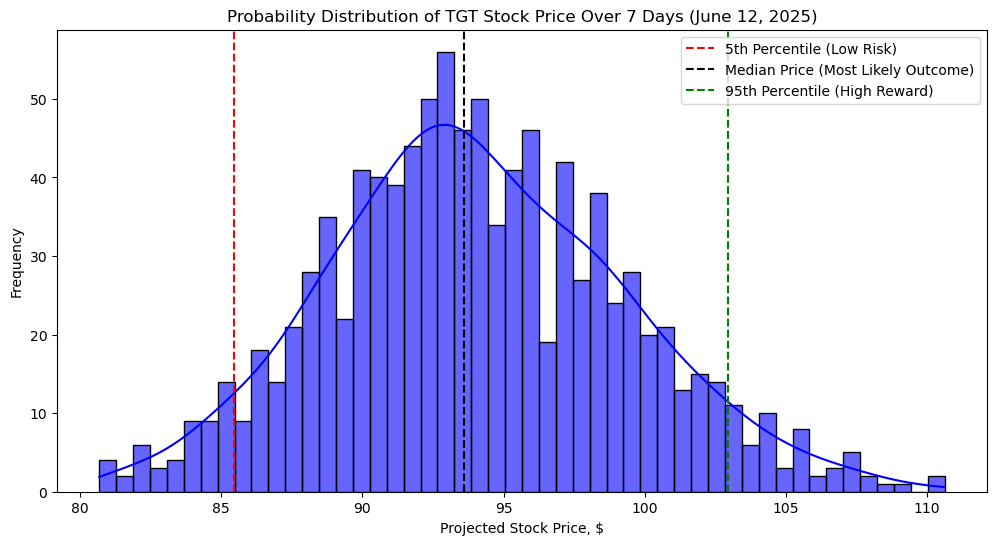

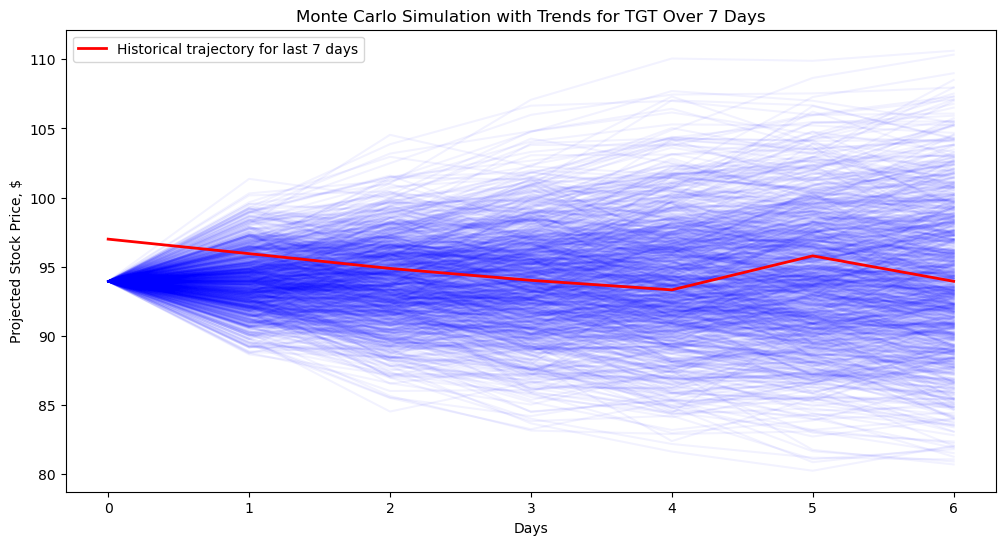

Monte Carlo Simulation for TGT - Projected Price on July 05, 2025:
5th Percentile (Low Risk Estimate): $77.54
Median Price (Most Likely Outcome): $93.60
95th Percentile (High Reward Estimate): $113.45



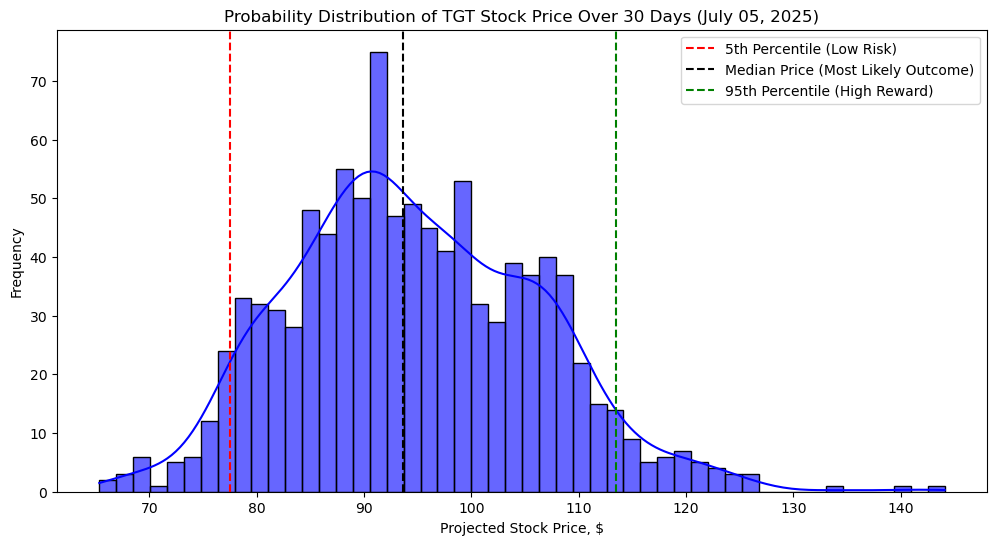

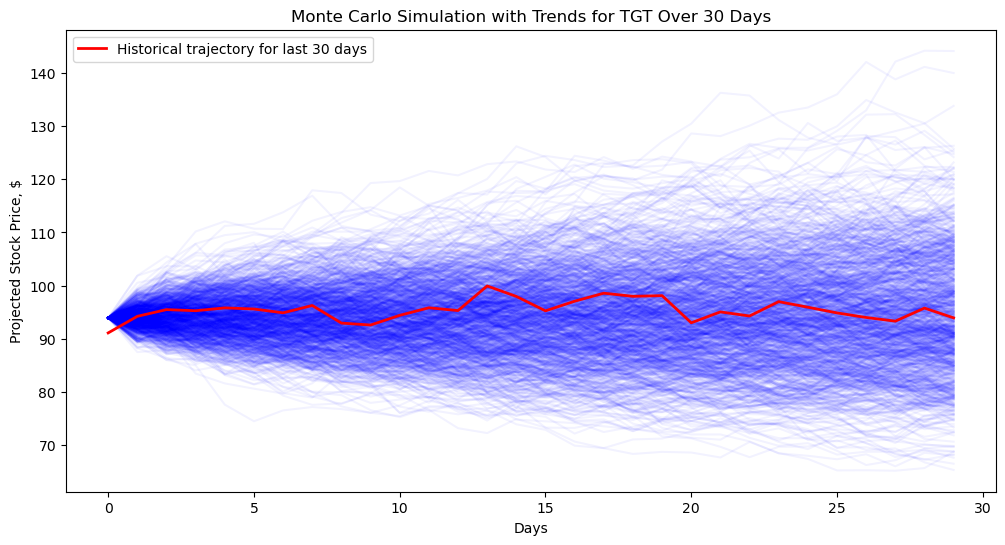

Monte Carlo Simulation for TGT - Projected Price on September 03, 2025:
5th Percentile (Low Risk Estimate): $64.45
Median Price (Most Likely Outcome): $93.01
95th Percentile (High Reward Estimate): $132.42



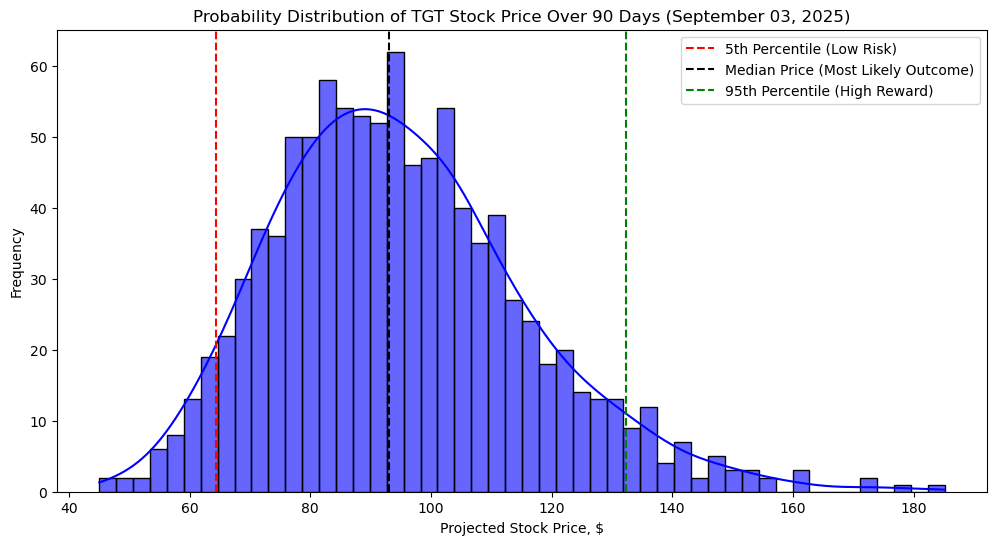

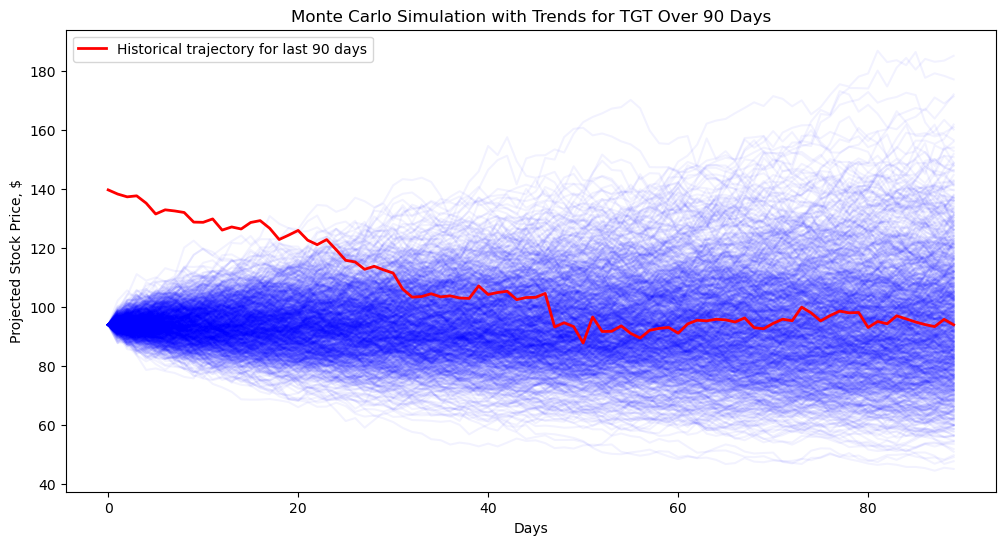

Monte Carlo Simulation for TGT - Projected Price on December 02, 2025:
5th Percentile (Low Risk Estimate): $54.56
Median Price (Most Likely Outcome): $93.09
95th Percentile (High Reward Estimate): $152.28



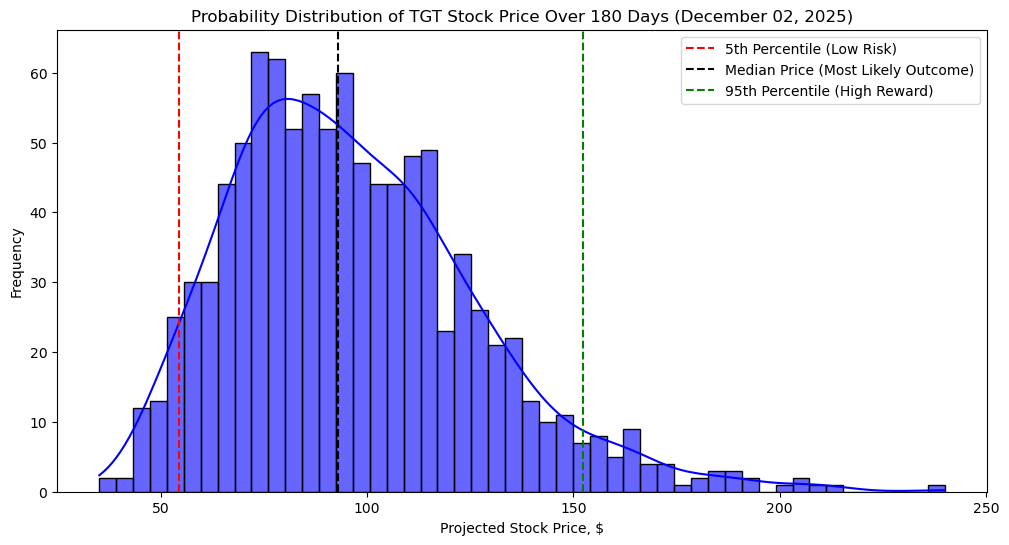

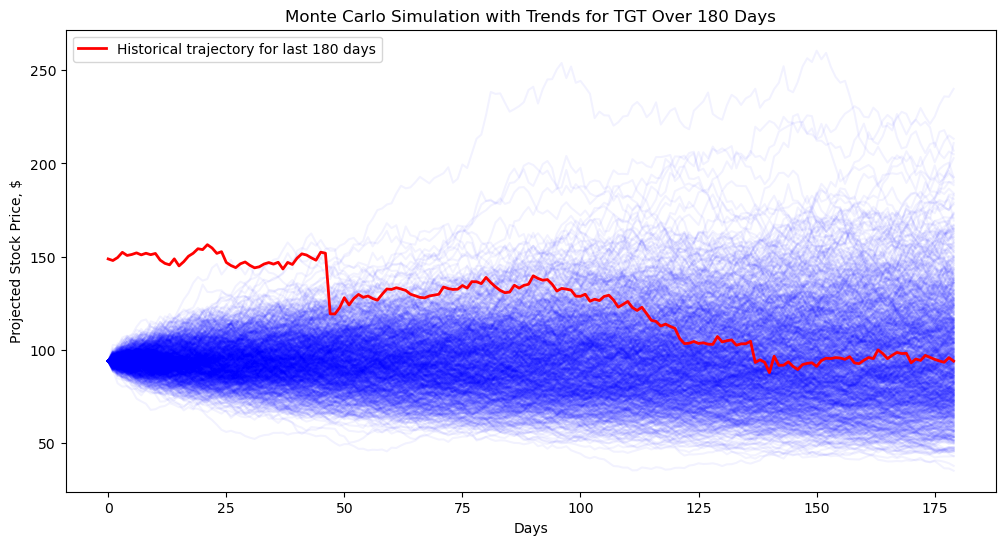

Monte Carlo Simulation for TGT - Projected Price on June 05, 2026:
5th Percentile (Low Risk Estimate): $43.07
Median Price (Most Likely Outcome): $91.67
95th Percentile (High Reward Estimate): $187.63



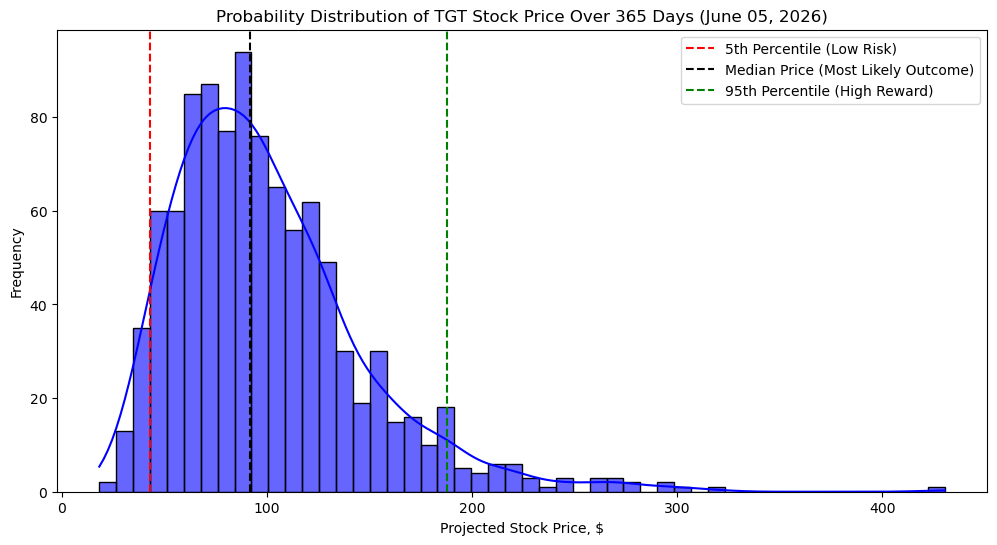

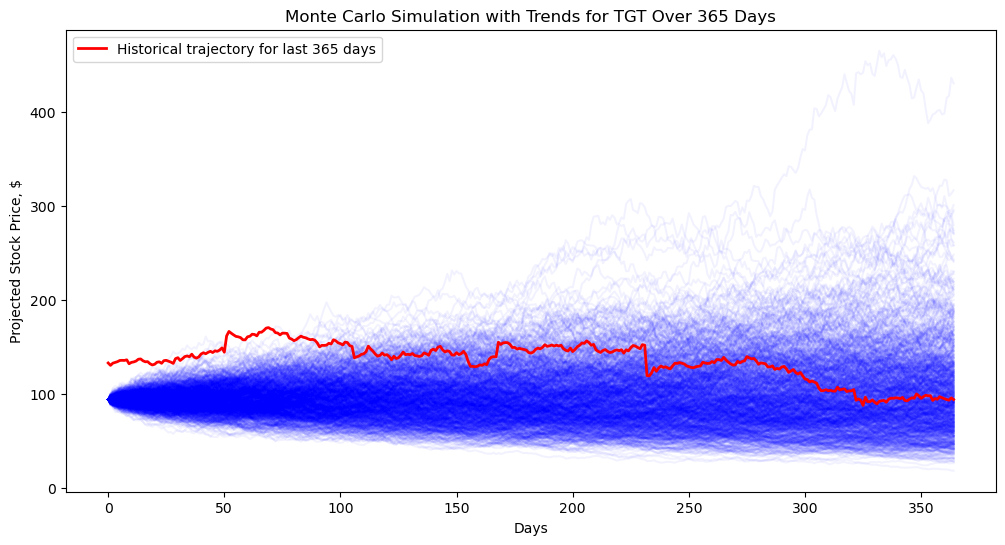

In [38]:
monte_carlo(tckr)